In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ../TileEM/

/home/jlee782/crowd-seg/analysis/TileEM


In [3]:
from TileEM_plot_toolbox import *
from qualityBaseline import *
from glob import glob

In [4]:
worker_Nbatches={5:10,10:8,15:6,20:4,25:2,30:1}
sampleN_lst=worker_Nbatches.keys()
Nsample_lst = worker_Nbatches.keys()

# Dataset Characterization 

- CITE previous literature show three types of error : worker response can identify the wrong object (ambiguous), low-precision BBs (sloppy), underdraw/overdraw. 
	\todo[inline]{- basic characterization of our dataset to show that the worker responses are indeed noisy} 
		- stats: \% overdraw and underdraw
		- variance in ground truth P,R 

In [5]:
len(load_info())

4

In [6]:
img_info,object_tbl,bb_info,hits_info = load_info()

In [64]:
underbounding_lst=[]
overbounding_lst=[]
bb_area_lst =[]
diff_area_lst = []
my_BBG  = pd.read_csv("my_ground_truth.csv")
#for bb in tqdm(list(bb_info.iterrows())):
for objid in tqdm(object_lst):
    bb_obj=bb_info[bb_info["object_id"]==objid]
    underbounding=0
    overbounding=0
    for bb in list(bb_obj.iterrows()):
        objid = bb[1]["object_id"]

        #Image information 
        image_id = int(object_tbl[object_tbl.object_id==oid].image_id)
        img_name = img_info["filename"][image_id-1]

        bbx_path= bb[1]["x_locs"]
        bby_path= bb[1]["y_locs"]
        worker_x_locs,worker_y_locs= process_raw_locs([bbx_path,bby_path])
        bb = Polygon(zip(worker_x_locs,worker_y_locs))

        ground_truth_match = my_BBG[my_BBG.object_id==objid]
        x_locs,y_locs =  process_raw_locs([ground_truth_match["x_locs"].iloc[0],ground_truth_match["y_locs"].iloc[0]])
        BBG = shapely.geometry.Polygon(zip(x_locs,y_locs))

        if bb.area< BBG.area:
            underbounding+=1
        else: 
            overbounding+=1
        bb_area_lst.append(bb.area)
        diff_area_lst.append(bb.area-BBG.area)
    underbounding_lst.append(underbounding)
    overbounding_lst.append(overbounding)

In [53]:
underbounding_lst=np.array(underbounding_lst,dtype=float)
overbounding_lst=np.array(overbounding_lst,dtype=float)

In [60]:
underbounding_rate = underbounding_lst/(underbounding_lst+overbounding_lst)
overbounding_rate = overbounding_lst/(underbounding_lst+overbounding_lst)
print "underbounding rate:" ,mean(underbounding_rate), std(underbounding_rate)
print "overbounding rate:" , mean(overbounding_rate), std(overbounding_rate)

underbounding rate: 0.496514253763 0.270778411512
overbounding rate: 0.503485746237 0.270778411512


(array([ 7.,  5.,  4.,  5.,  2.,  9.,  4.,  3.,  4.,  4.]),
 array([ 0.075 ,  0.1675,  0.26  ,  0.3525,  0.445 ,  0.5375,  0.63  ,
         0.7225,  0.815 ,  0.9075,  1.    ]),
 <a list of 10 Patch objects>)

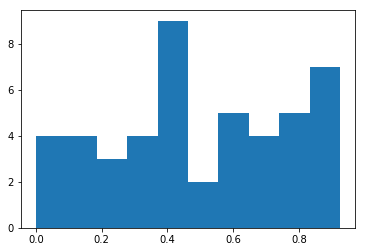

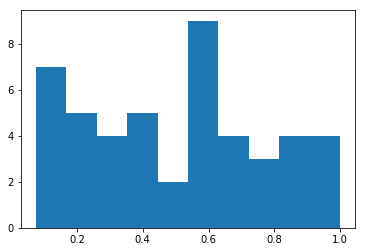

In [62]:
plt.hist(underbounding_rate)
plt.figure()
plt.hist(overbounding_rate)

In [43]:
underbounding

914

In [44]:
overbounding

914

In [26]:
len(list(bb_info.iterrows()))

1828

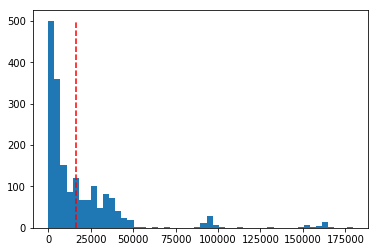

In [39]:
a = plt.hist(bb_area_lst,bins=50)
plt.vlines(BBG.area,0,500,'red','--')

The rate at which people underbound and overbound is around 50%-50% with a variance of around 25%. The degree to which workers overbound is larger for the overbounding case than the underbounding case. 

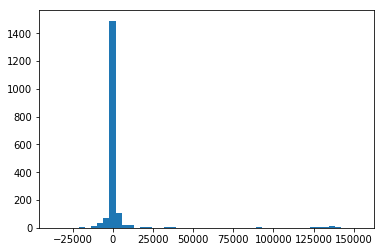

In [68]:
a = plt.hist(diff_area_lst,bins=50)

In [71]:
diff_area = np.array(diff_area_lst)

In [79]:
print "On average workers overbound by A=",mean(diff_area[np.where(diff_area>0)[0]])
print "On average workers underbound by A=",mean(diff_area[np.where(diff_area<0)[0]])
print "Median workers overbound by A=",median(diff_area[np.where(diff_area>0)[0]])
print "Median workers underbound by A=",median(diff_area[np.where(diff_area<0)[0]])

On average workers overbound by A= 7212.04552483
On average workers underbound by A= -1306.42940165
Median workers overbound by A= 419.25
Median workers underbound by A= -388.25


# Data Cleaning 

In [110]:
df = pd.read_csv("sample{}_PR.csv".format(Nsample))

In [158]:
def data_clean(df):
    df = df.rename(index=str,columns={'P [Jaccard [Self]]':'P [GT Jaccard]','R [Jaccard [Self]]':'R [GT Jaccard]',\
                             'P [Precision [Self]]':'P [GT Precision]','R [Precision [Self]]':'R [GT Precision]',\
                             'P [Recall [Self]]':'P [GT Recall]','R [Recall [Self]]':'R [GT Recall]',\
                            })
    return df

In [128]:
cd ../../

/home/jlee782/crowd-seg/analysis/TileEM


In [132]:
!head sample/5worker_rand0/GT_PR.csv

,object_id,GT Tile-based Precision,GT Tile-based Recall,GT A_thres
0,1.0,0.855648597987,0.0137677108438,8.55574936081
1,2.0,0.962618197179,0.988098861007,8.65030551591
2,3.0,0.939695634287,0.0953050511189,12.0998322968
3,4.0,0.969633047666,0.942834706765,12.6494919022
4,5.0,0.951914039969,0.932063870362,9.46507853613
5,6.0,0.961494644526,0.900493208855,1.20887445887
6,7.0,0.949913341055,0.582125183454,13.9084555858
7,8.0,0.959388054276,0.939566305633,38.3304901577
8,9.0,0.986354695668,0.965070369103,8.48617570338


In [145]:
df.to_csv

In [139]:
cd ../../

/home/jlee782/crowd-seg/analysis/TileEM


Working on : 10worker_rand6
C error crashed so no GT_PR table created

In [201]:
cd ../../

/home/jlee782/crowd-seg/analysis/TileEM


In [204]:
df = df.merge(PR_tbl[["object_id","P [GT Tile-based]","R [GT Tile-based]"]],on="object_id")

In [219]:
cd ../../

/home/jlee782/crowd-seg/analysis/TileEM


In [251]:
PR_tbl = pd.read_csv("GT_PR.csv",index_col=0)

In [271]:
cd ../../

/home/jlee782/crowd-seg/analysis/TileEM


In [326]:
for Nworker in sampleN_lst:
    for batch_num in range(worker_Nbatches[Nworker]):
        dir_name = "{0}worker_rand{1}".format(Nworker,batch_num)
        df = pd.read_csv("sample/"+dir_name+"/PR_tbl_all.csv",index_col=0)
        df=data_clean(df)
        print "Working on :", dir_name
        os.chdir("sample/"+dir_name)
        try:
            PR_tbl = pd.read_csv("GT_PR.csv",index_col=0)
            
            visionPR = pd.read_csv("../../PR.csv")
            PR_tbl["P [Vision GT 50%]"] = visionPR["precision"]
            PR_tbl["R [Vision GT 50%]"] = visionPR["recall"]
            PR_tbl = PR_tbl.rename(index=str,columns={'GT Tile-based Precision':'P [GT Tile-based]','GT Tile-based Recall':'R [GT Tile-based]'})
            df = df.drop(["P [Vision GT 50%]","R [Vision GT 50%]"],axis=1)
            df = df.merge(PR_tbl[["object_id","P [GT Tile-based]","R [GT Tile-based]","P [Vision GT 50%]","R [Vision GT 50%]"]],on="object_id")
            df.to_csv("PR_tbl_updated.csv")
        except(IOError):
            print dir_name+"failed"
            pass 
        
        os.chdir("../../")

Working on : 5worker_rand0
Working on : 5worker_rand1
Working on : 5worker_rand2
Working on : 5worker_rand3
Working on : 5worker_rand4
Working on : 5worker_rand5
Working on : 5worker_rand6
Working on : 5worker_rand7
Working on : 5worker_rand8
Working on : 5worker_rand9
Working on : 10worker_rand0
Working on : 10worker_rand1
Working on : 10worker_rand2
Working on : 10worker_rand3
Working on : 10worker_rand4
Working on : 10worker_rand5
Working on : 10worker_rand6
10worker_rand6failed
Working on : 10worker_rand7
Working on : 15worker_rand0
Working on : 15worker_rand1
Working on : 15worker_rand2
Working on : 15worker_rand3
Working on : 15worker_rand4
Working on : 15worker_rand5
Working on : 20worker_rand0
Working on : 20worker_rand1
Working on : 20worker_rand2
Working on : 20worker_rand3
Working on : 25worker_rand0
Working on : 25worker_rand1
Working on : 30worker_rand0


In [327]:
from bad_vtiles import *

In [329]:
# elif mode =="aggregate_sample_table" :
sampleN_lst=sorted(worker_Nbatches.keys())

for Nworker in sampleN_lst:
    print "Working on worker = ",Nworker
    batch_all_data=[]
    for batch_num in range(worker_Nbatches[Nworker]):
        dir_name = "sample/{0}worker_rand{1}".format(Nworker,batch_num)
        try:
            batch_i_data=pd.read_csv(dir_name+"/PR_tbl_updated.csv",index_col=0)
            #Drop the object rows where the objects have bad vtiles to begin with
            bad_vtile_objs = list(problematic[(problematic["Nworker"]==Nworker)&(problematic["batch_num"]==batch_num)].objid)
            bad_vtile_objs.extend([35,41]) # Discard ambiguous objects
            batch_i_data=batch_i_data.drop(bad_vtile_objs,errors='ignore')
            #batch_i_data[~batch_i_data["object_id"].isin(bad_vtile_objs)]
            # First set the object_id column the index, then reindex based on this index to correspond to object lst
            # This fills in a row of NaN for the missing data objects, so it normalizes the shape of our data table
            batch_i_data = batch_i_data.set_index('object_id').reindex(object_lst,fill_value =0)
             # Add a row of non-nan count for averaging
            nan_rowidx= list(batch_i_data[batch_i_data["P [Num Points]"]==0].index)
            non_nan_count = np.ones_like(object_lst)
            #non_nan_count = np.ones(47)
            for row in nan_rowidx: non_nan_count[row-1]=0
            batch_i_data["non_nan_count"]=non_nan_count
            if batch_num==0:
                batch_all_data=batch_i_data
            else:
                batch_all_data+=batch_i_data
        except(IOError):
            print dir_name+"failed"
            pass 
    try:
        batch_all_data=batch_all_data[batch_all_data.keys()[:-1]].divide(batch_all_data["non_nan_count"],axis=0)
        batch_all_data[batch_all_data>1]=1
        batch_all_data[batch_all_data<0]=0
        print "Created sample{}_PR.csv".format(Nworker)
        batch_all_data.to_csv("sample{}_PR.csv".format(Nworker))
    except(ZeroDivisionError):
        print "No data for worker=",Nworker

Working on worker =  5
Created sample5_PR.csv
Working on worker =  10
sample/10worker_rand6failed
Created sample10_PR.csv
Working on worker =  15
Created sample15_PR.csv
Working on worker =  20
Created sample20_PR.csv
Working on worker =  25
Created sample25_PR.csv
Working on worker =  30
Created sample30_PR.csv



# Sample 5 worker 

In [275]:
'P [GT Tile-based]', u'R [GT Tile-based]'

Index([u'object_id', u'P [Num Points]', u'R [Num Points]', u'P [Area Ratio]',
       u'R [Area Ratio]', u'P [GT Jaccard]', u'R [GT Jaccard]',
       u'P [GT Precision]', u'R [GT Precision]', u'P [GT Recall]',
       u'R [GT Recall]', u'P [Vision Best Area Ratio 50%]',
       u'R [Vision Best Area Ratio 50%]', u'P [Vision Best Num Points 50%]',
       u'R [Vision Best Num Points 50%]', u'P [Vision GT 10%]',
       u'R [Vision GT 10%]', u'P [Vision GT 90%]', u'R [Vision GT 90%]',
       u'P [TileEM]', u'R [TileEM]', u'P [MVT]', u'R [MVT]', u'P [MVTtop10]',
       u'R [MVTtop10]', u'P [MVTtop95%]', u'R [MVTtop95%]',
       u'P [GT Tile-based]', u'R [GT Tile-based]', u'P [Vision GT 50%]',
       u'R [Vision GT 50%]'],
      dtype='object')

In [298]:
attr_lst = ['Num Points','Area Ratio','GT Jaccard','GT Precision','GT Recall',
            'Vision Best Area Ratio 50%','Vision Best Num Points 50%','Vision GT 10%','Vision GT 10%',\
            'Vision GT 50%','Vision GT 90%','GT Tile-based',\
            'TileEM','MVT','MVTtop10','MVTtop95%']
selected_attr_lst = ['Num Points','Area Ratio','TileEM','MVT','GT Tile-based','GT Precision','GT Recall','GT Jaccard',\
                     'Vision Best Area Ratio 50%','Vision Best Num Points 50%','Vision GT 50%']

selected_col_lst =[]
for attr in selected_attr_lst:
    selected_col_lst.append("P [{}]".format(attr))
    selected_col_lst.append("R [{}]".format(attr))

P [Num Points]                    0.828265
R [Num Points]                    0.881949
P [Area Ratio]                    0.729513
R [Area Ratio]                    0.896200
P [TileEM]                        0.895974
R [TileEM]                        0.872810
P [MVT]                           0.783246
R [MVT]                           0.467139
P [GT Tile-based]                 0.917714
R [GT Tile-based]                 0.786388
P [GT Precision]                  0.926970
R [GT Precision]                  0.798353
P [GT Recall]                     0.804006
R [GT Recall]                     0.928872
P [GT Jaccard]                    0.900227
R [GT Jaccard]                    0.906841
P [Vision Best Area Ratio 50%]    0.733294
R [Vision Best Area Ratio 50%]    0.758940
P [Vision Best Num Points 50%]    0.803261
R [Vision Best Num Points 50%]    0.768190
P [Vision GT 50%]                 0.907324
R [Vision GT 50%]                 0.735262
dtype: float64

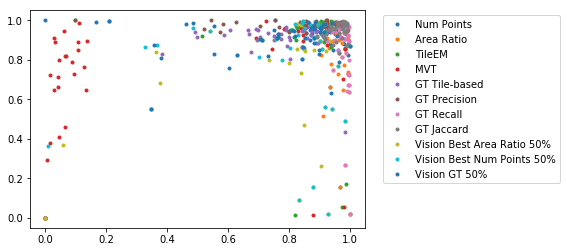

In [313]:
Nsample=5
df = pd.read_csv("sample{}_PR.csv".format(Nsample))

for attr in selected_attr_lst:
    plt.plot(df["R [{}]".format(attr)],df["P [{}]".format(attr)],'.',label=attr)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

df[selected_col_lst].mean()

P [Num Points]                    0.828265
R [Num Points]                    0.881949
P [Area Ratio]                    0.729513
R [Area Ratio]                    0.896200
P [TileEM]                        0.895974
R [TileEM]                        0.872810
P [MVT]                           0.783246
R [MVT]                           0.467139
P [GT Tile-based]                 0.904896
R [GT Tile-based]                 0.544933
P [GT Precision]                  0.926970
R [GT Precision]                  0.798353
P [GT Recall]                     0.804006
R [GT Recall]                     0.928872
P [GT Jaccard]                    0.900227
R [GT Jaccard]                    0.906841
P [Vision Best Area Ratio 50%]    0.733294
R [Vision Best Area Ratio 50%]    0.758940
P [Vision Best Num Points 50%]    0.803261
R [Vision Best Num Points 50%]    0.768190
P [Vision GT 50%]                 0.907324
R [Vision GT 50%]                 0.735262
dtype: float64

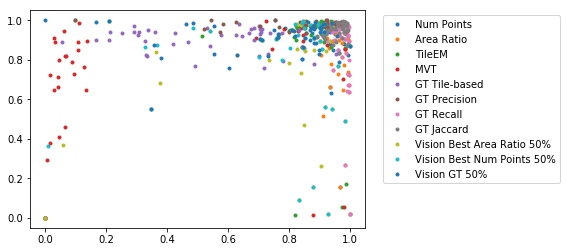

In [314]:
Nsample=10
df = pd.read_csv("sample{}_PR.csv".format(Nsample))

for attr in selected_attr_lst:
    plt.plot(df["R [{}]".format(attr)],df["P [{}]".format(attr)],'.',label=attr)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

df[selected_col_lst].mean()

P [Num Points]                    0.828265
R [Num Points]                    0.881949
P [Area Ratio]                    0.729513
R [Area Ratio]                    0.896200
P [TileEM]                        0.895974
R [TileEM]                        0.872810
P [MVT]                           0.783246
R [MVT]                           0.467139
P [GT Tile-based]                 0.928452
R [GT Tile-based]                 0.478816
P [GT Precision]                  0.926970
R [GT Precision]                  0.798353
P [GT Recall]                     0.804006
R [GT Recall]                     0.928872
P [GT Jaccard]                    0.900227
R [GT Jaccard]                    0.906841
P [Vision Best Area Ratio 50%]    0.733294
R [Vision Best Area Ratio 50%]    0.758940
P [Vision Best Num Points 50%]    0.803261
R [Vision Best Num Points 50%]    0.768190
P [Vision GT 50%]                 0.907324
R [Vision GT 50%]                 0.735262
dtype: float64

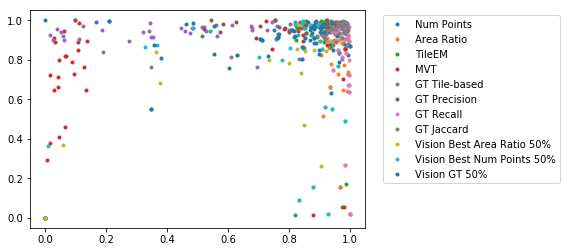

In [315]:
Nsample=15
df = pd.read_csv("sample{}_PR.csv".format(Nsample))

for attr in selected_attr_lst:
    plt.plot(df["R [{}]".format(attr)],df["P [{}]".format(attr)],'.',label=attr)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

df[selected_col_lst].mean()


P [Num Points]                    0.828265
R [Num Points]                    0.881949
P [Area Ratio]                    0.729513
R [Area Ratio]                    0.896200
P [TileEM]                        0.895974
R [TileEM]                        0.872810
P [MVT]                           0.783246
R [MVT]                           0.467139
P [GT Tile-based]                 0.892243
R [GT Tile-based]                 0.398061
P [GT Precision]                  0.926970
R [GT Precision]                  0.798353
P [GT Recall]                     0.804006
R [GT Recall]                     0.928872
P [GT Jaccard]                    0.900227
R [GT Jaccard]                    0.906841
P [Vision Best Area Ratio 50%]    0.733294
R [Vision Best Area Ratio 50%]    0.758940
P [Vision Best Num Points 50%]    0.803261
R [Vision Best Num Points 50%]    0.768190
P [Vision GT 50%]                 0.907324
R [Vision GT 50%]                 0.735262
dtype: float64

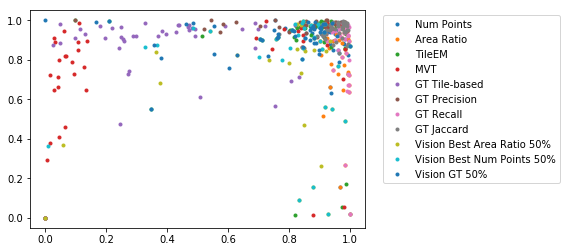

In [290]:
Nsample=20
df = pd.read_csv("sample{}_PR.csv".format(Nsample))

for attr in selected_attr_lst:
    plt.plot(df["R [{}]".format(attr)],df["P [{}]".format(attr)],'.',label=attr)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

df[selected_col_lst].mean()


P [Num Points]                    0.828265
R [Num Points]                    0.881949
P [Area Ratio]                    0.729513
R [Area Ratio]                    0.896200
P [TileEM]                        0.895974
R [TileEM]                        0.872810
P [MVT]                           0.783246
R [MVT]                           0.467139
P [GT Tile-based]                 0.899385
R [GT Tile-based]                 0.369982
P [GT Precision]                  0.926970
R [GT Precision]                  0.798353
P [GT Recall]                     0.804006
R [GT Recall]                     0.928872
P [GT Jaccard]                    0.900227
R [GT Jaccard]                    0.906841
P [Vision Best Area Ratio 50%]    0.733294
R [Vision Best Area Ratio 50%]    0.758940
P [Vision Best Num Points 50%]    0.803261
R [Vision Best Num Points 50%]    0.768190
P [Vision GT 50%]                 0.907324
R [Vision GT 50%]                 0.735262
dtype: float64

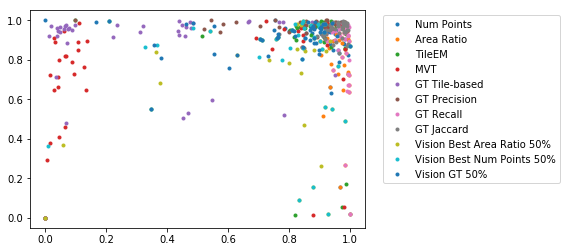

In [291]:
Nsample=25
df = pd.read_csv("sample{}_PR.csv".format(Nsample))

for attr in selected_attr_lst:
    plt.plot(df["R [{}]".format(attr)],df["P [{}]".format(attr)],'.',label=attr)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

df[selected_col_lst].mean()


P [Num Points]                    0.828265
R [Num Points]                    0.881949
P [Area Ratio]                    0.729513
R [Area Ratio]                    0.896200
P [TileEM]                        0.895974
R [TileEM]                        0.872810
P [MVT]                           0.783246
R [MVT]                           0.467139
P [GT Tile-based]                 0.902697
R [GT Tile-based]                 0.265966
P [GT Precision]                  0.926970
R [GT Precision]                  0.798353
P [GT Recall]                     0.804006
R [GT Recall]                     0.928872
P [GT Jaccard]                    0.900227
R [GT Jaccard]                    0.906841
P [Vision Best Area Ratio 50%]    0.733294
R [Vision Best Area Ratio 50%]    0.758940
P [Vision Best Num Points 50%]    0.803261
R [Vision Best Num Points 50%]    0.768190
P [Vision GT 50%]                 0.907324
R [Vision GT 50%]                 0.735262
dtype: float64

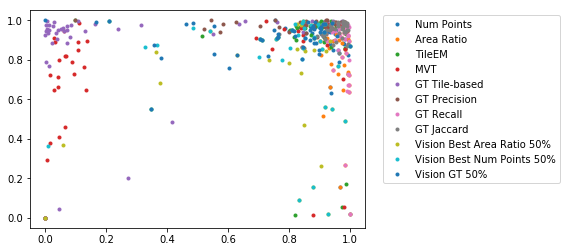

In [292]:
Nsample=30
df = pd.read_csv("sample{}_PR.csv".format(Nsample))

for attr in selected_attr_lst:
    plt.plot(df["R [{}]".format(attr)],df["P [{}]".format(attr)],'.',label=attr)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

df[selected_col_lst].mean()


Metrics used in Irshad et al 

$$sensitivity = TPR = \frac{|A(T)\bigcap A(S)|}{|A(T)|} = recall $$
$$specificity = TNR = \frac{|A(I)-(A(T)\bigcup A(S))|}{|A(I)-A(T)|}$$
$$ F1 measure = 2*\frac{P*R}{P+R}$$

Upper limit to vision 

In [331]:
from tabulate import tabulate

In [332]:
df_all = pd.DataFrame()
cols  = []
for Nsample in sorted(Nsample_lst):
    df = pd.read_csv("sample{}_PR.csv".format(Nsample))
    df=data_clean(df)
    cols.append(Nsample)
    df_all[Nsample]=df[selected_col_lst].mean()

In [333]:
pd.options.display.float_format = '{:,.3f}'.format

In [334]:
#reordering columns so that sort by category + limit 
df_all.reindex([u'P [Num Points]', u'R [Num Points]', u'P [Area Ratio]',
               u'R [Area Ratio]',u'P [GT Precision]', u'R [GT Precision]', u'P [GT Recall]',
               u'R [GT Recall]',u'P [GT Jaccard]', u'R [GT Jaccard]', u'P [TileEM]', u'R [TileEM]', u'P [MVT]', u'R [MVT]',u'P [GT Tile-based]'
               ,u'R [GT Tile-based]', u'P [Vision Best Area Ratio 50%]',
               u'R [Vision Best Area Ratio 50%]', u'P [Vision Best Num Points 50%]',
               u'R [Vision Best Num Points 50%]', u'P [Vision GT 50%]',
               u'R [Vision GT 50%]'])

,5,10,15,20,25,30
P [Num Points],0.856,0.847,0.826,0.833,0.862,0.890
R [Num Points],0.890,0.881,0.888,0.897,0.919,0.938
P [Area Ratio],0.787,0.738,0.696,0.676,0.619,0.720
R [Area Ratio],0.910,0.913,0.908,0.894,0.891,0.933
P [GT Precision],0.927,0.934,0.937,0.938,0.954,0.985
R [GT Precision],0.836,0.814,0.807,0.801,0.817,0.846
P [GT Recall],0.837,0.822,0.801,0.797,0.786,0.845
R [GT Recall],0.923,0.934,0.939,0.941,0.961,0.989
P [GT Jaccard],0.910,0.916,0.917,0.917,0.934,0.967
R [GT Jaccard],0.907,0.913,0.916,0.918,0.937,0.966


In [301]:
PR = pd.read_csv("sample/10worker_rand0/PR_tbl_all.csv")

In [188]:
PR[PR["object_id"]==40]

,Unnamed: 0,object_id,P [Num Points],R [Num Points],P [Area Ratio],R [Area Ratio],P [Jaccard [Self]],R [Jaccard [Self]],P [Precision [Self]],R [Precision [Self]],...,P [Vision GT 90%],R [Vision GT 90%],P [TileEM],R [TileEM],P [MVT],R [MVT],P [MVTtop10],R [MVTtop10],P [MVTtop95%],R [MVTtop95%]
37,37,40,0.019005,1,0.019005,1,0.931817,0.766411,0.969952,0.704208,...,1,0.050533,0.01569,0.819621,0.016797,0.878719,0.013302,0.692692,0.011176,0.580713


In [179]:
Tstar = pkl.load(open("sample/10worker_rand0/Tstar_obj40.pkl"))

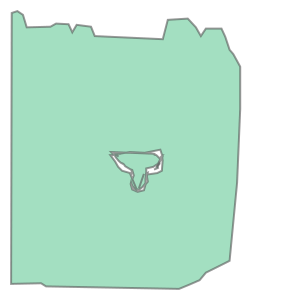

In [181]:
Tstar[0][0]

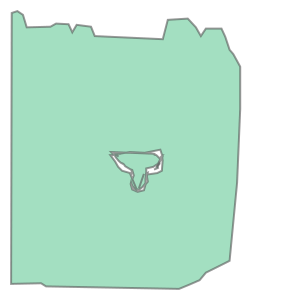

In [182]:
Tstar[-1][0]

In [165]:
# df_all.index

In [195]:
print tabulate(df_all,floatfmt=".2f",showindex=True,headers="keys",tablefmt="latex")

\begin{tabular}{lrrrrrr}
\hline
                                &    5 &   10 &   15 &   20 &   25 &   30 \\
\hline
 P [Num Points]                 & 0.86 & 0.84 & 0.83 & 0.83 & 0.86 & 0.89 \\
 R [Num Points]                 & 0.89 & 0.88 & 0.89 & 0.90 & 0.92 & 0.94 \\
 P [Area Ratio]                 & 0.79 & 0.73 & 0.70 & 0.68 & 0.62 & 0.72 \\
 R [Area Ratio]                 & 0.91 & 0.91 & 0.91 & 0.89 & 0.89 & 0.93 \\
 P [TileEM]                     & 0.89 & 0.92 & 0.92 & 0.93 & 0.94 & 0.98 \\
 R [TileEM]                     & 0.85 & 0.86 & 0.86 & 0.82 & 0.79 & 0.83 \\
 P [MVT]                        & 0.82 & 0.82 & 0.79 & 0.77 & 0.77 & 0.86 \\
 R [MVT]                        & 0.72 & 0.56 & 0.46 & 0.35 & 0.35 & 0.28 \\
 P [GT Precision]               & 0.93 & 0.93 & 0.94 & 0.94 & 0.95 & 0.99 \\
 R [GT Precision]               & 0.84 & 0.81 & 0.81 & 0.80 & 0.82 & 0.85 \\
 P [GT Recall]                  & 0.84 & 0.82 & 0.80 & 0.80 & 0.79 & 0.85 \\
 R [GT Recall]                  & 0.9

In [ ]:
4,5,6

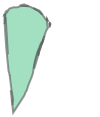

In [340]:
objid=4
Tstar_lst = pkl.load(open("sample/15worker_rand0/Tstar_obj{}.pkl".format(objid)))

Tstar_lst[-1][0]

Ring Self-intersection at or near point 453.38709677419354 172.32258064516128


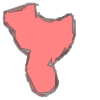

In [341]:
objid=5
Tstar_lst = pkl.load(open("sample/15worker_rand0/Tstar_obj{}.pkl".format(objid)))

Tstar_lst[-1][0]

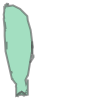

In [342]:
objid=6
Tstar_lst = pkl.load(open("sample/15worker_rand0/Tstar_obj{}.pkl".format(objid)))

Tstar_lst[-1][0]

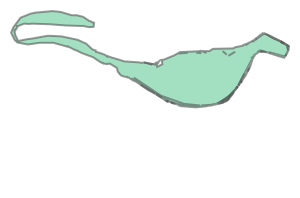

In [343]:
objid=8
Tstar_lst = pkl.load(open("sample/15worker_rand0/Tstar_obj{}.pkl".format(objid)))

Tstar_lst[-1][0]